In [1]:
import pandas as pd

In [2]:
# Import patients file
patients_file = "https://github.com/spiros/nkua-health-data-science/raw/master/data/dest/patients.csv.gz"
df_patients = pd.read_csv(patients_file)

In [3]:
# Display number of rows and values in loaded file
df_patients.shape

(1162, 25)

In [4]:
# Display the first three rows of the dataframe
df_patients.head(3)

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,...,BIRTHPLACE,ADDRESS,CITY,STATE,COUNTY,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE
0,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,2019-02-17,NaN,999-65-3251,NaN,NaN,NaN,Damon455,Langosh790,NaN,...,Middleborough Massachusetts US,620 Lynch Tunnel Apt 0,Springfield,Massachusetts,Hampden County,1104.0,42.080389,-72.480431,9039.1645,7964.1255
1,339144f8-50e1-633e-a013-f361391c4cff,1998-05-11,NaN,999-10-8743,S99996708,X75063318X,Mr.,Chi716,Greenfelder433,NaN,...,Athens Athens Prefecture GR,1060 Bernhard Crossroad Suite 15,Boston,Massachusetts,Suffolk County,2131.0,42.292557,-71.061160,571935.8725,787.5375
2,d488232e-bf14-4bed-08c0-a82f34b6a197,2003-01-28,1999-01-01,999-56-6057,S99929424,NaN,Ms.,Phillis443,Walter473,NaN,...,Boston Massachusetts US,677 Ritchie Terrace,Hingham,Massachusetts,Plymouth County,2043.0,42.200491,-70.916076,582557.8030,104782.2070


In [5]:
# Drop columns that are not required
c_to_drop = [
    'SSN',
    'DRIVERS',
    'PASSPORT',
    'PREFIX',
    'FIRST',
    'LAST',
    'SUFFIX',
    'MAIDEN',
    'MARITAL',
    'BIRTHPLACE',
    'ADDRESS',
    'CITY',
    'STATE',
    'COUNTY',
    'ZIP',
    'LAT',
    'LON',
    'HEALTHCARE_EXPENSES',
    'HEALTHCARE_COVERAGE'
]

df_patients.drop(columns=c_to_drop, inplace=True)

In [6]:
# Display the first three rows of the dataframe
df_patients.head(3)

,Id,BIRTHDATE,DEATHDATE,RACE,ETHNICITY,GENDER
0,b9c610cd-28a6-4636-ccb6-c7a0d2a4cb85,2019-02-17,NaN,white,nonhispanic,M
1,339144f8-50e1-633e-a013-f361391c4cff,1998-05-11,NaN,white,nonhispanic,M
2,d488232e-bf14-4bed-08c0-a82f34b6a197,2003-01-28,1999-01-01,white,nonhispanic,F


In [7]:
# Display data types
df_patients.dtypes

Id           object
BIRTHDATE    object
DEATHDATE    object
RACE         object
ETHNICITY    object
GENDER       object
dtype: object

In [8]:
# The date of birth and the date of death should be a datetime
# Convert the BIRTHDATE column to a datetime column. If you try to convert the 
# column directly, an error will occur as some values are not valid dates.
# Adding the "errors=coerce" will convert any invalid dates e.g. malformed, strings, numbers etc
# into missing values
df_patients['BIRTHDATE'] = pd.to_datetime(
    df_patients['BIRTHDATE'],
    errors='coerce'
)

df_patients['DEATHDATE'] = pd.to_datetime(
    df_patients['DEATHDATE'],
    errors='coerce'
)

df_patients.dtypes

Id                   object
BIRTHDATE    datetime64[ns]
DEATHDATE    datetime64[ns]
RACE                 object
ETHNICITY            object
GENDER               object
dtype: object

In [9]:
# Number of unique patients
df_patients.Id.nunique()

1162

In [10]:
# Rows where the patient id is missing
df_patients[df_patients['Id'].isna()]

,Id,BIRTHDATE,DEATHDATE,RACE,ETHNICITY,GENDER


In [11]:
# Create a flag for patient exclusion called 'exclude' and set default value to 0
df_patients['exclude'] = 0

In [12]:
# Count unique values for GENDER
df_patients.GENDER.value_counts(dropna=False)

GENDER
F         600
M         538
NaN        20
8293.3      4
Name: count, dtype: int64

In [13]:
# Exclude patients with invalid or missing gender
valid_genders = ['F', 'M']
m = (df_patients.GENDER.isna())|(~df_patients.GENDER.isin(valid_genders))
df_patients.loc[m, 'exclude'] = 1

In [14]:
# Count unique values for ETHNICITY
df_patients.ETHNICITY.value_counts(dropna=False)

ETHNICITY
nonhispanic    1057
hispanic        105
Name: count, dtype: int64

In [15]:
# Count unique values for RACE
df_patients.RACE.value_counts(dropna=False)

RACE
white       944
black        96
asian        72
hawaiian     16
XJniDSe      15
other        11
???-          6
native        2
Name: count, dtype: int64

In [16]:
# Exclude patients with invalid RACE values
valid_race = ['white', 'black', 'asian', 'hawaiian', 'other', 'native']
m = (df_patients.RACE.isna())|(~df_patients.RACE.isin(valid_race))
df_patients.loc[m, 'exclude'] = 1

In [17]:
# Display and exclude patients with an invalid date of birth
# Date of birth is missing
m = (df_patients.BIRTHDATE.isna())
df_patients.loc[m, 'exclude'] = 1
df_patients[df_patients.BIRTHDATE.isna()]

,Id,BIRTHDATE,DEATHDATE,RACE,ETHNICITY,GENDER,exclude
326,8a69ae35-07ad-e093-0162-ad02d8e1e070,NaT,NaT,white,nonhispanic,M,1
457,0a168e32-7b62-8597-0e11-296871bb764f,NaT,NaT,black,nonhispanic,M,1
573,3b7ccd6e-f331-abc9-a498-a16280c3ee10,NaT,NaT,white,nonhispanic,F,1
874,42daa5f0-9beb-4d16-322b-9df14bbe418b,NaT,1992-01-06,white,nonhispanic,F,1


In [18]:
# Find and exclude patients were the date of birth is after the date of death
m = df_patients['BIRTHDATE']>df_patients['DEATHDATE']
df_patients.loc[m, 'exclude'] = 1 
df_patients[df_patients['BIRTHDATE']>df_patients['DEATHDATE']]

,Id,BIRTHDATE,DEATHDATE,RACE,ETHNICITY,GENDER,exclude
2,d488232e-bf14-4bed-08c0-a82f34b6a197,2003-01-28,1999-01-01,white,nonhispanic,F,1
229,965ecf4b-40d6-02e3-fe08-acd9eafc68fe,2034-01-01,2002-12-06,white,nonhispanic,M,1
661,e0b4bd84-4df2-d30c-cd67-a9daee769602,2034-01-01,2005-03-17,white,nonhispanic,M,1
777,4fadd99c-4f13-0c0f-2b37-2c3c9c13ff78,2034-01-01,1966-05-07,white,nonhispanic,M,1
781,71feb043-65a2-618f-8a43-77990c308b76,2034-01-01,2013-12-13,white,nonhispanic,F,1
1049,79e131ae-ef35-fe33-f806-df3c5ed41b11,2034-01-01,1994-04-22,white,nonhispanic,F,1


<AxesSubplot:ylabel='Frequency'>

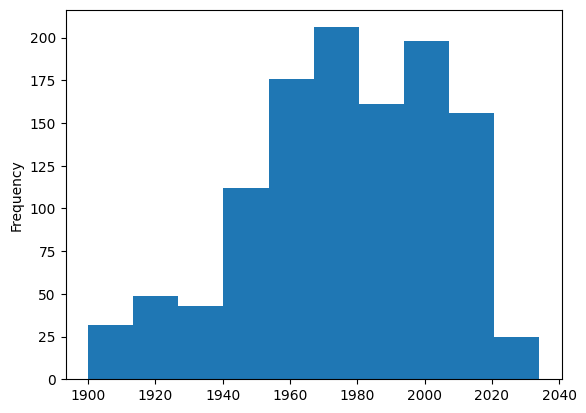

In [19]:
# Find and exclude patients with a year of birth before 1910 
# or after 2021
df_patients.BIRTHDATE.dt.year.plot(kind='hist')

In [20]:
m = (df_patients.BIRTHDATE.dt.year < 1910)|(df_patients.BIRTHDATE.dt.year > 2021)
print(df_patients.loc[m].shape)
df_patients.loc[m, 'exclude'] = 1

(19, 7)


In [21]:
df_patients[df_patients['exclude']==0].BIRTHDATE.min()

Timestamp('1911-07-14 00:00:00')

In [22]:
df_patients[df_patients['exclude']==1].BIRTHDATE.min()

Timestamp('1900-01-01 00:00:00')

In [23]:
df_patients.exclude.value_counts()

exclude
0    1093
1      69
Name: count, dtype: int64

In [24]:
df_patients.dtypes

Id                   object
BIRTHDATE    datetime64[ns]
DEATHDATE    datetime64[ns]
RACE                 object
ETHNICITY            object
GENDER               object
exclude               int64
dtype: object

In [25]:
import matplotlib.pyplot as plt
from scipy import stats

df_patients.drop(df_patients[df_patients['exclude']==1].index, inplace=True)
cond_file = "https://github.com/spiros/nkua-health-data-science/raw/master/data/dest/conditions.csv.gz"
df_cond = pd.read_csv(cond_file)
obs_file = "https://github.com/spiros/nkua-health-data-science/raw/master/data/dest/observations.csv.gz"
df_obs = pd.read_csv(obs_file)

df_cond.sort_values(['PATIENT', 'START'], inplace=True)
df_ht = df_cond[df_cond['CODE']==59621000.0].groupby('PATIENT').first().reset_index()
df_ht.drop(columns=['STOP', 'ENCOUNTER', 'CODE'], inplace=True)

df_patients_ht = df_patients.merge(df_ht, how='left', left_on='Id', right_on='PATIENT')
df_patients_ht.drop(columns=['PATIENT'], inplace=True)

df_patients_ht_bp = df_obs.merge(
    df_patients_ht, 
    how='left',
    left_on='PATIENT', 
    right_on='Id')

df_patients_ht_bp['hypertension'] = df_patients_ht_bp.apply(lambda x: 1 if pd.notna(x.START) else 0, axis=1)

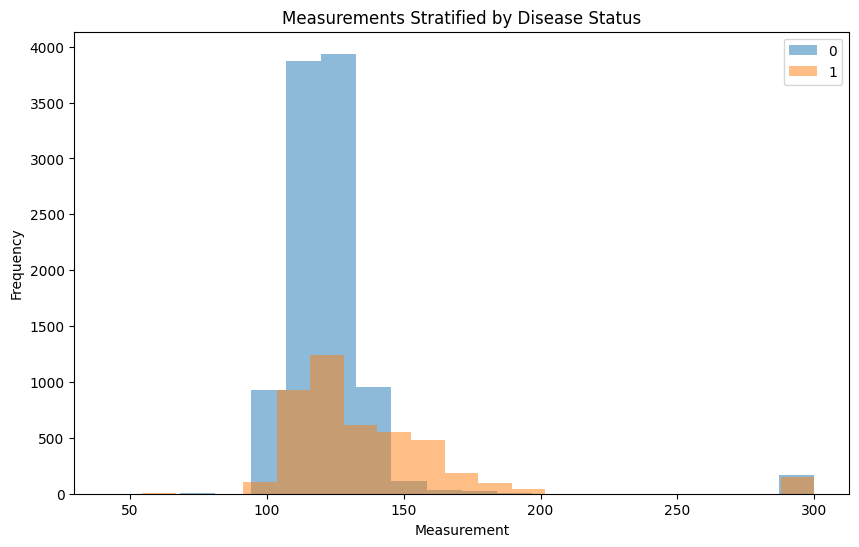

In [184]:
plt.figure(figsize=(10, 6))

dx_code = '8480-6'
for status, group in df_patients_ht_bp[df_patients_ht_bp['CODE']==dx_code].groupby('hypertension'):
    group['VALUE'].astype('float').plot(kind='hist', alpha=0.5, label=status, bins=20, stacked=True)

plt.legend()
plt.title('Diastolic blood pressure Stratified by Disease Status')
plt.xlabel('Measurement')  # or another relevant label for the x-axis
plt.ylabel('Frequency')
plt.show()

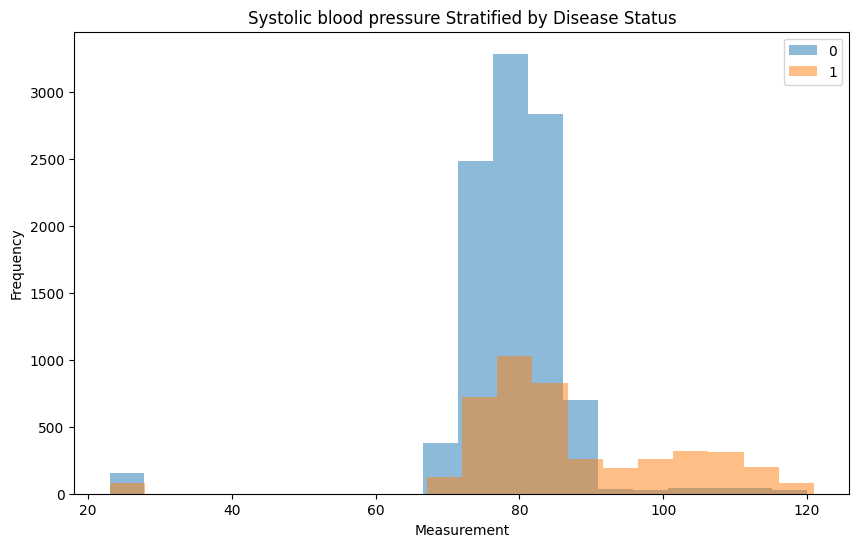

In [185]:
plt.figure(figsize=(10, 6))

dx_code = '8462-4'
for status, group in df_patients_ht_bp[df_patients_ht_bp['CODE']==dx_code].groupby('hypertension'):
    group['VALUE'].astype('float').plot(kind='hist', alpha=0.5, label=status, bins=20, stacked=True)

plt.legend()
plt.title('Systolic blood pressure Stratified by Disease Status')
plt.xlabel('Measurement')  # or another relevant label for the x-axis
plt.ylabel('Frequency')
plt.show()


In [196]:
m = (df_patients_ht_bp['CODE']==dx_code)&(df_patients_ht_bp['hypertension']==1)
bp_ht = df_patients_ht_bp[m].VALUE.astype(float).values
m = (df_patients_ht_bp['CODE']==dx_code)&(df_patients_ht_bp['hypertension']==0)
bp_nonht = df_patients_ht_bp[m].VALUE.astype(float).values

t_statistic, p_value = stats.ttest_ind(bp_ht, bp_nonht)

print("T-statistic:", t_statistic)
print("p-value:", p_value)

T-statistic: 34.48359110406919
p-value: 1.7703630428189084e-250
